# TRAINING

In [1]:
import keras
from keras.optimizers import SGD, Adam, Nadam
from keras.applications import MobileNetV2
from keras.layers import Input, PReLU, Lambda, DepthwiseConv2D, ZeroPadding2D, Conv2DTranspose, Conv2D, concatenate, LeakyReLU, BatchNormalization, Activation, UpSampling2D, Reshape, Permute
from keras.models import Model
from skimage.transform import resize
import numpy as np
import tensorflow as tf



Using TensorFlow backend.


In [0]:
# nb_labels = 6

input_shape = [224, 224, 3]
input_height, input_width, _ = input_shape
smoothness = 1.0
weights = 'imagenet'
IMAGE_ORDERING = 'channels_last'

n_classes = 3


In [3]:
input_tensor = keras.layers.Input(shape=input_shape)

x = MobileNetV2(weights='imagenet',include_top=False, input_tensor=input_tensor) 

# Freeze all convolutional MobileNetV2 layers
for layer in x.layers:
    layer.trainable = False


size_112_out_name = 'expanded_conv_project_BN'
size_56_out_name = 'block_2_project_BN'
size_28_out_name = 'block_5_project_BN'
size_14_out_name = 'block_12_project_BN'
size_7a_out_name = 'block_16_project_BN'
size_7_out_name = 'out_relu'

size_112_out = x.get_layer(size_112_out_name).output
size_56_out = x.get_layer(size_56_out_name).output
size_28_out = x.get_layer(size_28_out_name).output
size_14_out = x.get_layer(size_14_out_name).output
size_7a_out = x.get_layer(size_7a_out_name).output
size_7_out = x.get_layer(size_7_out_name).output


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '







9412608/9406464 [==============================] - 2s 0us/step


In [4]:
import keras.backend as K

def depth_softmax(matrix):
    #sigmoid = lambda x: 1 / (1 + K.exp(-x))
    #sigmoided_matrix = sigmoid(matrix)
    #softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=2)
    #softmax_matrix = sigmoided_matrix / K.expand_dims(K.sum(sigmoided_matrix, axis=-1), axis=-1)

    exp_matrix = K.exp(matrix)
    softmax_matrix = exp_matrix / K.expand_dims(K.sum(exp_matrix, axis=-1), axis=-1)

    return softmax_matrix


def segnet_decoder(  size_7_out, size_7a_out, size_14_out, size_28_out, size_56_out, size_112_out , n_classes ):
  
    # 32, 64, 96, 160, 320, 1280

# flast 7 X 7 X 1280
	#o = size_7_out
	#o = ( Conv2D(320, (3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	#o = ( concatenate([size_7a_out, o], axis=3))
	#o = ( Conv2D(320, (3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	#o = ( BatchNormalization())(o)

# f320 7 X 7 X 320
	o = size_7a_out
	#o = ( ZeroPadding2D( (1,1) , data_format=IMAGE_ORDERING ))(o)
	o = ( Conv2DTranspose(320, 4, strides=2, padding='same'))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( PReLU(init='zero', weights=None, shared_axes=[1, 2]))(o)
	#o = ( SpatialDropout2D(0.2))(o)
	o = ( DepthwiseConv2D((3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( Conv2D(320, (3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	o = ( concatenate([size_14_out, o], axis=3))
	#o = ( LeakyReLU(alpha=0.3))(o)
# 14 X 14 X 320


	#o = ( UpSampling2D( (2,2), data_format=IMAGE_ORDERING))(o)
	#o = ( ZeroPadding2D( (1,1), data_format=IMAGE_ORDERING))(o)
	o = ( Conv2DTranspose(160, 4, strides=2, padding='same'))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( PReLU(init='zero', weights=None, shared_axes=[1, 2]))(o)
	#o = ( SpatialDropout2D(0.2))(o)
	o = ( DepthwiseConv2D((3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( Conv2D( 160, (3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	o = ( concatenate([size_28_out, o], axis=3))
	#o = ( LeakyReLU(alpha=0.3))(o)
# 28 X 28 X 160
 

	#o = ( UpSampling2D( (2,2), data_format=IMAGE_ORDERING))(o)
	#o = ( ZeroPadding2D( (1,1), data_format=IMAGE_ORDERING))(o)
	o = ( Conv2DTranspose(96, 4, strides=2, padding='same'))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( PReLU(init='zero', weights=None, shared_axes=[1, 2]))(o)
	#o = ( SpatialDropout2D(0.2))(o)
	o = ( DepthwiseConv2D((3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( Conv2D( 96, (3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	o = ( concatenate([size_56_out, o], axis=3))
	#o = ( LeakyReLU(alpha=0.3))(o)
# 56 X 56 X 96
  

	#o = ( UpSampling2D( (2,2), data_format=IMAGE_ORDERING))(o)
	#o = ( ZeroPadding2D( (1,1), data_format=IMAGE_ORDERING))(o)
	o = ( Conv2DTranspose(64, 4, strides=2, padding='same'))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( PReLU(init='zero', weights=None, shared_axes=[1, 2]))(o)
	#o = ( SpatialDropout2D(0.2))(o)
	o = ( DepthwiseConv2D((3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( Conv2D( 64, (3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	o = ( concatenate([size_112_out, o], axis=3))
	#o = ( LeakyReLU(alpha=0.3))(o)
# 112 X 112 X 64
  

	#o = ( UpSampling2D( (2,2), data_format=IMAGE_ORDERING))(o)
	#o = ( ZeroPadding2D( (1,1), data_format=IMAGE_ORDERING))(o)
	o = ( Conv2DTranspose(32, 4, strides=2, padding='same'))(o)
	#o = ( concatenate([size_112_out, o], axis=3))
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( PReLU(init='zero', weights=None, shared_axes=[1, 2]))(o)
	#o = ( SpatialDropout2D(0.2))(o)
	o = ( DepthwiseConv2D((3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
	o = ( Conv2D( 32, (3, 3), padding='same', data_format=IMAGE_ORDERING))(o)
	o = ( BatchNormalization())(o)
	#o = ( LeakyReLU(alpha=0.3))(o)
# 224 X 224 X 32

	o =  Conv2D( n_classes , (3, 3) , padding='same', activation='softmax', data_format=IMAGE_ORDERING )( o )
	#o =  Conv2D( n_classes , (3, 3) , padding='same', activation='sigmoid', data_format=IMAGE_ORDERING )( o )
	#o =  Conv2D( n_classes , (3, 3) , padding='same', data_format=IMAGE_ORDERING )( o )
	#o =  Permute((1,2,3)) ( o )
	#o =  BatchNormalization() ( o )
	#o =  Lambda(depth_softmax) ( o )
# 224 X 224 X 3

	return o 

# layer_out, 
x = segnet_decoder( size_7_out, size_7a_out, size_14_out, size_28_out, size_56_out, size_112_out , n_classes )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, shared_axes=[1, 2], alpha_initializer="zero")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, shared_axes=[1, 2], alpha_initializer="zero")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, shared_axes=[1, 2], alpha_initializer="zero")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, shared_axes=[1, 2], alpha_initializer="zero")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, shared_axes=[1, 2], alpha_initializer="zero")`


In [0]:
semseg_model = Model(inputs=input_tensor, outputs=x)


In [0]:
from keras.losses import binary_crossentropy
import keras.backend as K

 
'''
def dice_coeff(target, prediction):
    intersection = tf.math.logical_and(target, prediction)
    union = tf.math.logical_or(target, prediction)
    iou_score = tf.math.sum(intersection) / tf.math.sum(union)
    return iou_score
 
'''
def dice_accuracy(y_true, y_pred):
    smooth = 1.
    
    #y_true = preprocess(y_true)
    #y_pred = preprocess(y_pred)
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    score = intersection / union
    #score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score



def dice_coeff(y_true, y_pred):
    smooth = 1.
    
    #y_true = preprocess(y_true)
    #y_pred = preprocess(y_pred)
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    score = intersection / union
    #score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1. - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = (0.001*binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred))
    #loss = (binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred))
    return loss


def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)


def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss


In [7]:
# Adam(lr=1e-5)
opt = Adam(lr=9e-5, beta_1=0.5, amsgrad=True)
# opt = Nadam(lr=0.0002)
# opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) 
semseg_model.compile(optimizer = opt, loss=dice_loss, metrics=[dice_accuracy])



In [8]:
# If running on Google Drive, set gdrive to True
gdrive = True


if (gdrive):
    # Access files on the google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    
    # Path variables to access project relevant files
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'Colab Notebooks/Semantic_Segmentation/'
    
else:
    base_dir = './'
    
data_dir = base_dir + 'data/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os
import urllib.request
import zipfile
import pathlib
import glob


def download(base_dir, data_dir):
    


  print("Downloading data")

  url = 'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip'

  zip_file = 'data_road.zip'

  if (not (os.path.isfile('data_road.zip'))):
    urllib.request.urlretrieve(url, zip_file)
  
  else:
    size = os.path.getsize(zip_file)
    if (size == 470992343):
      print("data_road.zip is already available")
    else:
      os.remove(zip_file)
      urllib.request.urlretrieve(url, zip_file)  

      
  zip_ref = zipfile.ZipFile(zip_file, 'r')
  zip_ref.extractall(data_dir)
  zip_ref.close()


  # Removing files not required for the project
  remove_list = glob.iglob(os.path.join(train_path, 'gt_image_2', '*_lane_*.png'))
  
  for filepath in (remove_list):
    print("Deleting: ", filepath)
    try:
      input("Press Enter to continue, Cntrl C to exit ...")
      os.remove(filepath)
    except:
      print("Interrupted while deleting the file: ", filepath)
      sys.exit()
      
  
  print("Files extracted")

    

def getData(base_dir, data_dir):

  if (os.path.isdir(data_dir + "/data_road/training/")): 
    print('Data already exists')
  else:
    download(base_dir, data_dir)
  

  print("Training Set Count: ", len(next(os.walk(data_dir + "/data_road/training/image_2/"))[2]))
  print("Mask Set Count: ", len(next(os.walk(data_dir + "/data_road/training/gt_image_2/"))[2]))
  print("Test Set Count: ", len(next(os.walk(data_dir + "/data_road/testing/image_2/"))[2]))
  
  
getData(base_dir, data_dir)



Data already exists
Training Set Count:  289
Mask Set Count:  289
Test Set Count:  290


In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def image_mask_zip(image_datagen, mask_datagen):
    train_generator = zip(image_datagen, mask_datagen)
    for (img, mask) in train_generator:
        yield (img, mask)


SEED = 100

train_args = ImageDataGenerator(
    featurewise_std_normalization = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rotation_range = 30,
    shear_range = 0.01,
    zoom_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = True
)

validation_args = ImageDataGenerator(
    featurewise_std_normalization = True,
    validation_split=0.2
)

image_train = train_args.flow_from_directory(data_dir + 'data_road/training/', classes=['image_2'], class_mode=None, batch_size = 16, 
                                              subset='training', target_size = (input_height, input_width), shuffle=True, seed = SEED)

mask_train = train_args.flow_from_directory(data_dir + 'data_road/training/', classes=['gt_image_2'], class_mode=None, batch_size = 16, 
                                              subset='training', target_size = (input_height, input_width), shuffle=True, seed = SEED)

image_validation = validation_args.flow_from_directory(data_dir + 'data_road/training/', classes=['image_2'], class_mode=None, batch_size = 8, 
                                              subset='validation', target_size = (input_height, input_width), shuffle=True, seed = SEED)

mask_validation = validation_args.flow_from_directory(data_dir + 'data_road/training/', classes=['gt_image_2'], class_mode=None, batch_size = 8, 
                                              subset='validation', target_size = (input_height, input_width), shuffle=True, seed = SEED)

# Create custom generator for training images and masks
train_yield = image_mask_zip(image_train, mask_train)
validation_yield = image_mask_zip(image_validation, mask_validation)

# verbose=1, 
# Train your model here
# 30 + 10
epoch = 15

wtfile = base_dir + 'weights/semsegwt_{epoch:02d}.h5'

# patience=epochs_to_wait_for_improve
#early_stopping_callback = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

#checkpoint_callback = ModelCheckpoint(wtfile, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# cooldown - wait before resuming normal operation (i.e. beginning to monitor if there is any improvement in the monitored metric over a patience epochs).
# For example, let's say cooldown=5. After the learning rate is reduced, the algorithm waits 5 epochs before starting to monitor the metrics again. 
# So if there is no improvement in the metric and patience=10, the learning rate will be reduced again after 15 epochs.
lrScheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.9, min_lr=1e-5, patience=2, cooldown=0, verbose=1)


semseg_model.fit_generator(train_yield, steps_per_epoch=18, shuffle=True, epochs=epoch, validation_data=validation_yield, 
                            validation_steps=7, callbacks=[lrScheduler])



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 289 images belonging to 1 classes.
Found 289 images belonging to 1 classes.
Found 57 images belonging to 1 classes.
Found 57 images belonging to 1 classes.


Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/18 [==============================] - 204s 11s/step - loss: 0.6448 - dice_accuracy: 0.3552 - val_loss: 0.7701 - val_dice_accuracy: 0.2299
Epoch 2/15
18/18 [==============================] - 16s 916ms/step - loss: 0.5179 - dice_accuracy: 0.4821 - val_loss: 0.7006 - val_dice_accuracy: 0.2994
Epoch 3/15
18/18 [==============================] - 18s 995ms/step - loss: 0.3721 - dice_accuracy: 0.6279 - val_loss: 0.4870 - val_dice_accuracy: 0.5130
Epoch 4/15
18/18 [==============================] - 18s 997ms/step - loss: 0.2707 - dice_accuracy: 0.7293 - val_loss: 0.4416 - val_dice_accuracy: 0.5584
Epoch 5/15
18/18 [==============================] - 18s 1s/step - loss: 0.2339 - dice_accuracy: 0.7661 - val_loss: 0.4315 - val_dice_accuracy: 0.5685
Epoch 6/15
18/18 [==============================] - 18s 993ms/step - loss: 0.2162 - dice_accuracy: 0.7838 - val_loss: 0.4095 - val_dice_accuracy: 0.5905
Epoch 7/15
18/18 [==============================] - 18s 997ms/step - loss: 0.2030 - dice_accuracy

In [0]:
# Serialize model to JSON
model_json = semseg_model.to_json()
model_file = base_dir + 'weights/semsegmodel.json'
with open(model_file, "w") as json_file:
    json_file.write(model_json)


In [0]:

# save weights periodically
# epoch = 30
wtfile = base_dir + 'weights/semsegwt_%03d.h5' % (epoch)
semseg_model.save_weights(wtfile)
'''
'''


In [0]:
semseg_model.reset_states()

# EVALUATION

In [0]:
import keras
from keras.optimizers import Adam, Nadam
from keras.applications import MobileNetV2
from keras.layers import Input, PReLU, DepthwiseConv2D, ZeroPadding2D, Conv2DTranspose, Conv2D, concatenate, LeakyReLU, BatchNormalization, Activation, UpSampling2D, Reshape, Permute
from keras.models import Model
from skimage.transform import resize
import numpy as np
import tensorflow as tf



In [0]:
# If running on Google Drive, set gdrive to True
gdrive = True


if (gdrive):
    # Access files on the google drive
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    
    # Path variables to access project relevant files
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'Colab Notebooks/Semantic_Segmentation/'
    
else:
    base_dir = './'
    
data_dir = base_dir + 'data/'


In [0]:
from keras.models import model_from_json

# load json and create model
model_file = base_dir + 'weights/goodrun/semsegmodel_usualsoftmax.json'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
semseg_model = model_from_json(loaded_model_json)


In [0]:
semseg_model.summary()


In [22]:
# ----------------- Restore weights from previous good runs
# Restore saved weights

wtfile = base_dir + 'weights/goodrun/semsegwt_015_usualsoftmax.h5'

print("wt file path: ", wtfile)
semseg_model.load_weights(wtfile)


wt file path:  /content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/weights/goodrun/semsegwt_015_usualsoftmax.h5


In [11]:
import glob

test_path = data_dir + 'data_road/testing/image_2/*.png'
print(test_path)
# test_images = list(glob.iglob(os.path.join(test_path, 'image_2/', '*.png')))

test_images = list(glob.iglob(test_path))

test_images.sort()

print("Test Set count: ", len(test_images))


for i in range(10):
  print("\ntest path: ", test_images[i])
  


/content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/data/data_road/testing/image_2/*.png
Test Set count:  290

test path:  /content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/data/data_road/testing/image_2/um_000000.png

test path:  /content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/data/data_road/testing/image_2/um_000001.png

test path:  /content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/data/data_road/testing/image_2/um_000002.png

test path:  /content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/data/data_road/testing/image_2/um_000003.png

test path:  /content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/data/data_road/testing/image_2/um_000004.png

test path:  /content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/data/data_road/testing/image_2/um_000005.png

test path:  /content/gdrive/My Drive/Colab Notebooks/Semantic_Segmentation/data/data_road/testing/image_2/um_000006.png

test path:  /content/gdrive/My 

In [0]:
import cv2
from google.colab.patches import cv2_imshow
import scipy.misc
#import cv2_show

def preprocess_input(img, input_shape=(224, 224)):
    return cv2.resize(img, input_shape) / 255.0
  

def show_arr(arr):
    cv2_imshow(arr)
    cv2.waitKey()
    cv2.destroyAllWindows()


def process_image(img_org):
    # keras.losses.bce_dice_loss = helper.bce_dice_loss
    # keras.metrics.dice_coeff = helper.dice_coeff
    # model = mlflow.keras.load_model("runs:/{}/model".format(uri))

    img_arr = img_org.copy()
    height, width, _ = img_arr.shape

    img_arr = preprocess_input(img_arr)
    img_arr = np.expand_dims(img_arr, axis=0)

    img_pred = semseg_model.predict(img_arr)[0]
    img_pred = np.where(img_pred > 0.5, 255, 0).astype(np.uint8)

    #b_channel, g_channel, r_channel = cv2.split(img_pred)
    #img_pred = cv2.cvtColor(r_channel, cv2.COLOR_GRAY2RGB)
    
    lower_red = np.array([100,0,0]) 
    upper_red = np.array([255,0,0])
    mask = cv2.inRange(img_pred, lower_red, upper_red)
    masked_pred = np.copy(img_pred)
    img_pred[mask != 0] = [0, 0, 0]
    b, g, r = cv2.split(img_pred)
    img_pred = cv2.merge((b, b, r))   # convert red to green

    #img_pred = cv2.resize(np.repeat(img_pred, 3, axis=2), (256, 256))
    #img_arr = cv2.resize(img_org, (256, 256))

    img_pred = cv2.resize(img_pred, (256, 256))
    masked_pred = cv2.resize(masked_pred, (256, 256))
    img_arr = cv2.resize(img_org, (256, 256))

    img_concat = cv2.addWeighted(img_arr, 0.4, img_pred, 1.0, 0.)
    #print("img_pred shape: ", img_pred.shape)
    #print("img_arr shape: ", img_arr.shape)

    return (np.concatenate([img_arr, masked_pred, img_concat], axis=1))



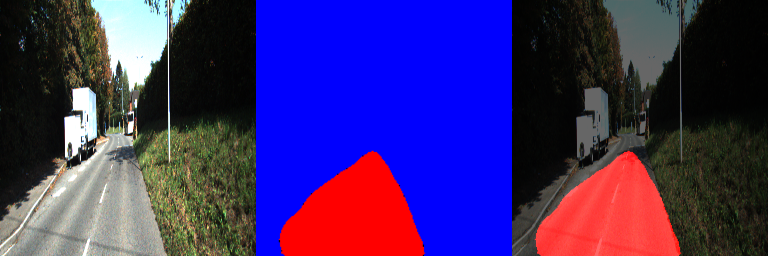

In [27]:
imgpath = test_images[22]

img_org = cv2.imread(imgpath)

predicted_image = process_image(img_org)

show_arr(predicted_image)


In [0]:
def process(img_org):
    # keras.losses.bce_dice_loss = helper.bce_dice_loss
    # keras.metrics.dice_coeff = helper.dice_coeff
    # model = mlflow.keras.load_model("runs:/{}/model".format(uri))

    img_arr = img_org.copy()
    height, width, _ = img_arr.shape

    img_arr = preprocess_input(img_arr)
    img_arr = np.expand_dims(img_arr, axis=0)

    img_pred = semseg_model.predict(img_arr)[0]
    img_pred = np.where(img_pred > 0.6, 255, 0).astype(np.uint8)    # BGR format
    #b_channel, g_channel, r_channel = cv2.split(img_pred)
    #img_pred = cv2.cvtColor(r_channel, cv2.COLOR_GRAY2RGB)
    lower_blue = np.array([100,0,0]) 
    upper_blue = np.array([255,0,0])

    # OpenCV by default reads images in BGR format.
    mask = cv2.inRange(img_pred, lower_blue, upper_blue)
    masked_pred = np.copy(img_pred)
    img_pred[mask != 0] = [0, 0, 0]
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB) #convert it into RGB format
    r, g, b = cv2.split(img_pred)     # RGB format
    img_pred = cv2.merge((b, r, b))   # b,r,b    green

    #img_pred = cv2.resize(np.repeat(img_pred, 3, axis=2), (256, 256))
    #img_arr = cv2.resize(img_org, (256, 256))

    img_pred = cv2.resize(img_pred, (width, height))
    masked_pred = cv2.resize(masked_pred, (width, height))
    img_arr = cv2.resize(img_org, (width, height))

    img_concat = cv2.addWeighted(img_arr, 1., img_pred, 1.0, 0.)
    #print("img_pred shape: ", img_pred.shape)
    #print("img_arr shape: ", img_arr.shape)

    return img_concat


In [0]:
from moviepy.editor import VideoFileClip

video_path = base_dir + 'project_video.mp4'
out_path = base_dir + 'project_out.mp4'

#white_output = 'project_out.mp4'

clip1 = VideoFileClip(video_path)
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
white_clip.write_videofile(out_path, audio=False)
